In [42]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

In [43]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import tempfile

from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

import tdgl
from tdgl.geometry import box, circle

In [44]:
tempdir = tempfile.TemporaryDirectory(dir=os.getcwd())

In [63]:
length_units = "um" 

# Material Parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 10
total_length = 5
link_width = total_width / 3

# Rectangle
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Source
source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.3 * total_length))
    .translate(dx=-total_width / 2)
)

# drain
drain = source.scale(xfact=-1).set_name("drain")

#  Voltage measurement points
probe_points = [(-total_width / 2.5, 0), (total_width / 2.5, 0)]

# Define device 
device = tdgl.Device(
    "plate",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)


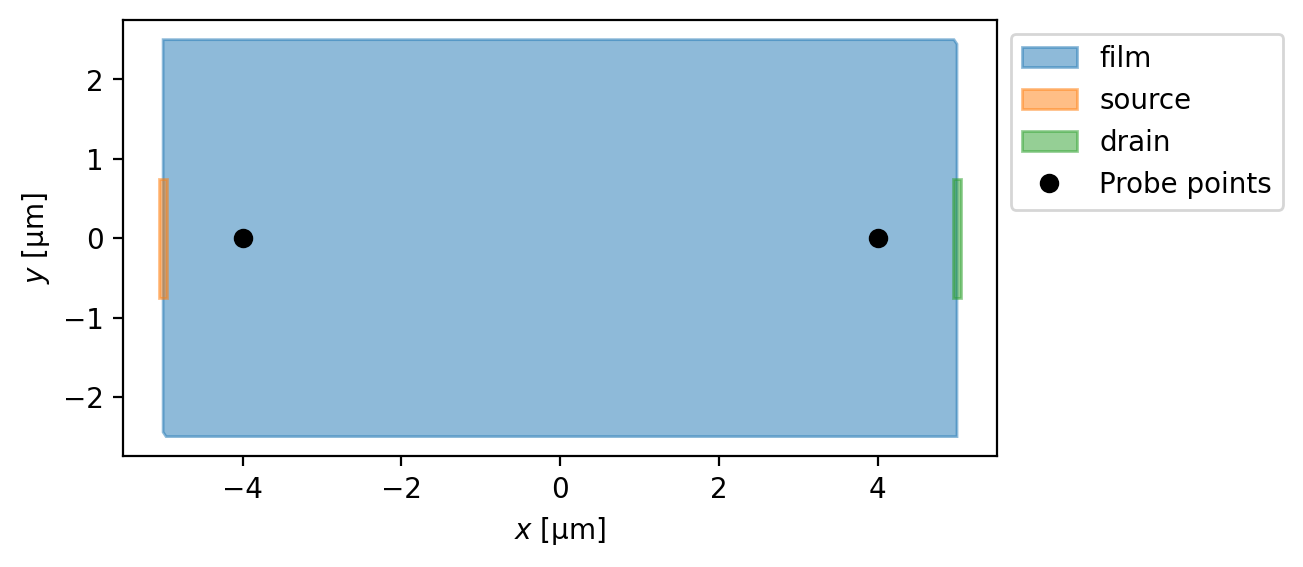

In [64]:
fig, ax = device.draw()

In [65]:
# options for solver
options = tdgl.SolverOptions(
    skip_time=100,
    solve_time=200,
    output_file=os.path.join(tempdir.name, "campo_corriente.h5"),
    field_units="mT",
    current_units="uA",
    save_every=100,
)

In [66]:
# make mesh
device.make_mesh(max_edge_length=xi/2, smooth=100)

Constructing Voronoi polygons: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:00<00:00, 8097.13it/s]


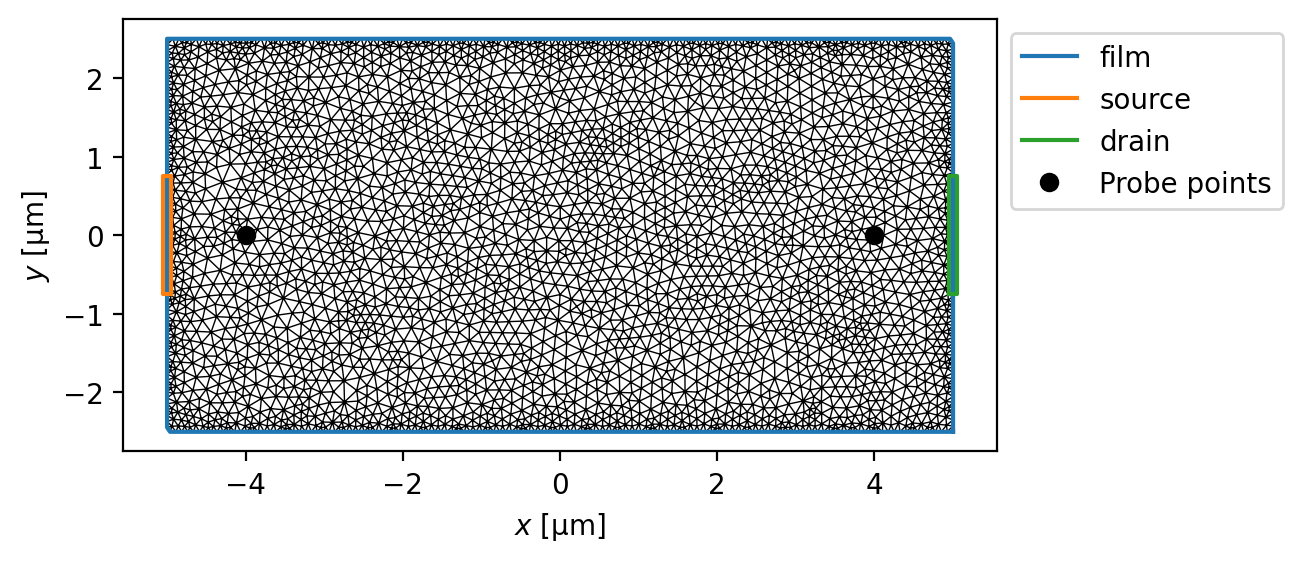

In [67]:
fig, ax = device.plot(mesh=True, legend=True)

# Simulación de las corrientes en el supercondutor

- I = 12 µA
- H = 0

Simulating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:04<00:00, 42.31tau/s ]


Measured current: 11.875 µA


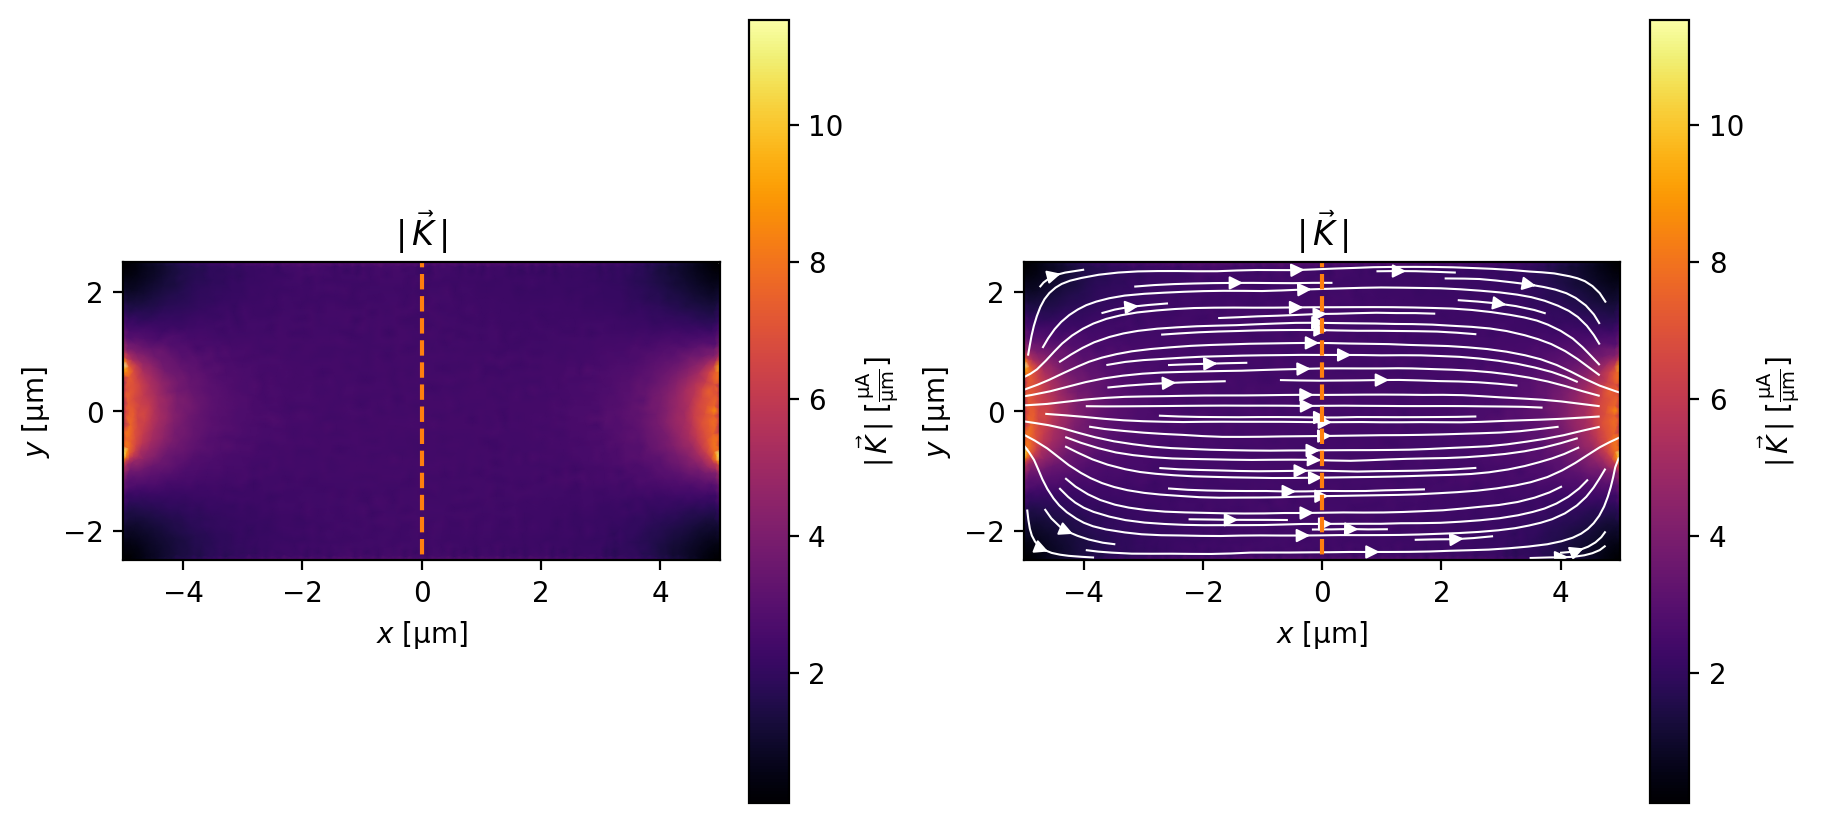

In [68]:
default_terminal_currents = {
    'source': 12,
    'drain': -12
}

H_zero_solution = tdgl.solve(device=device, options=options, terminal_currents=default_terminal_currents)

fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout= True)
_ = H_zero_solution.plot_currents(ax=axes[0], streamplot = False)
_ = H_zero_solution.plot_currents(ax=axes[1])

y = np.linspace(-total_width / 2, total_width / 2, 401)
x = np.zeros_like(y)

cross_section = np.array([x, y]).T

# Cross section draw
for ax in axes:
    _ = ax.plot(x, y, "C1--")

# current flux alongside cross section
current = H_zero_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")


In [ ]:
# Graph current vs voltage
def get_mean_voltage(device, options, current):
  terminal_currents = {
      'source': current,
      'drain': -current
  }

  solution = tdgl.solve(device=device, options=options, terminal_currents=terminal_currents)
  voltage = solution.dynamics.mean_voltage()
  return voltage

currents = np.arange(0.0, 50, 0.1)
voltages = []
intensities = []

voltage_current_csv_filename = "V_vs_I_lámina.csv"
csv_path = os.path.join("raw_data", voltage_current_csv_filename)

if os.path.exists(csv_path):
    os.remove(csv_path)

for current in currents:
    voltage = get_mean_voltage(device=device, options=options, current=current)
    voltages.append(voltage)
    intensities.append(current)
  
    csv_df = pd.DataFrame({'current_µA': [current], 'voltage_V': [voltage]})
    csv_df.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path), index=False)


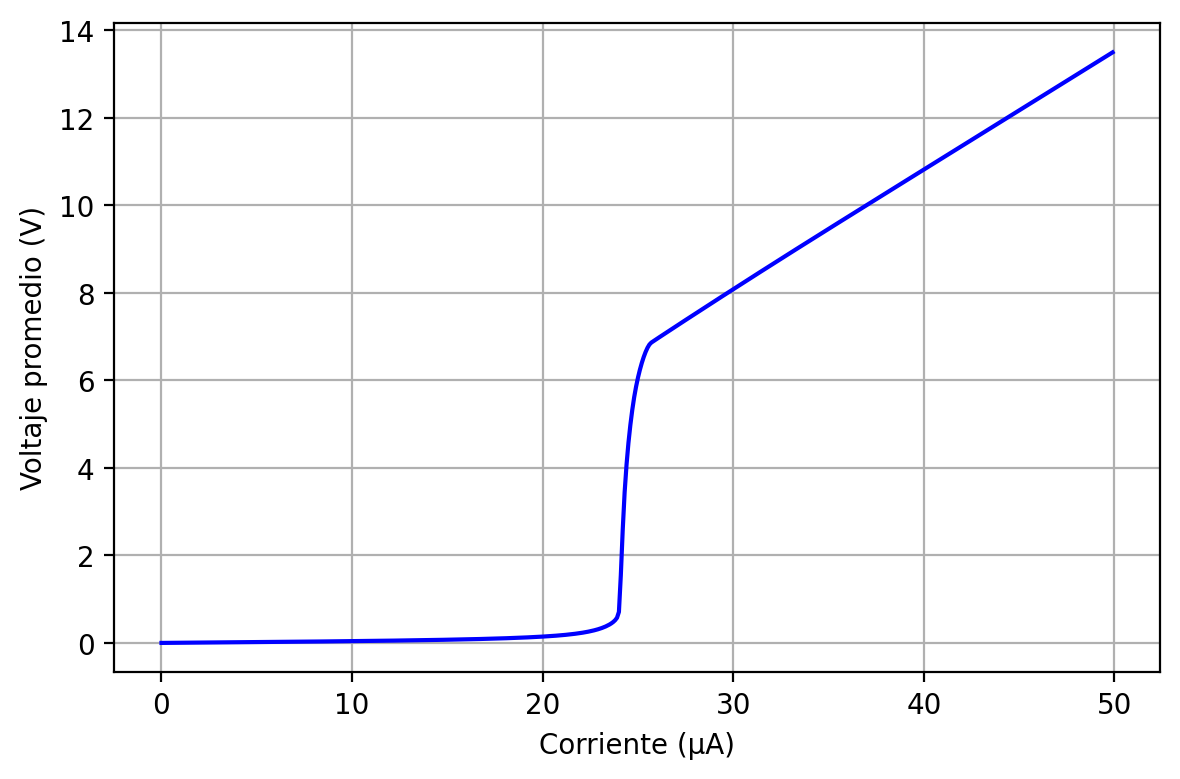

In [17]:
df = pd.read_csv(csv_path)
arr = df.to_numpy()

voltages = [a[1] for a in arr]
intensities = [a[0] for a in arr]

plt.figure(figsize=(6, 4))
plt.plot(intensities, voltages, linestyle='-', color='blue')
plt.xlabel('Corriente (µA)')
plt.ylabel('Voltaje promedio (V)')
plt.grid(True)
plt.tight_layout()
plt.show()